In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from utitlity_functions import *
import numpy as np
from matplotlib import pyplot as plt
import scienceplots
from scipy import ndimage
import cv2 as cv
from matplotlib import cm
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from hough_circle_trafo import hough_circle
np.random.seed(137)

# Example of plot

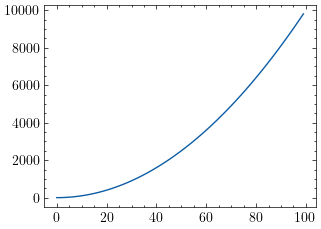

In [2]:
plt.style.use('science')
x=np.arange(100)
y=x**2
with plt.style.context('science'):
    plt.figure()
    plt.plot(x, y)
    plt.show()

In [3]:
im=cv.imread("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t193.jpg", cv.IMREAD_GRAYSCALE)


# Plot Image

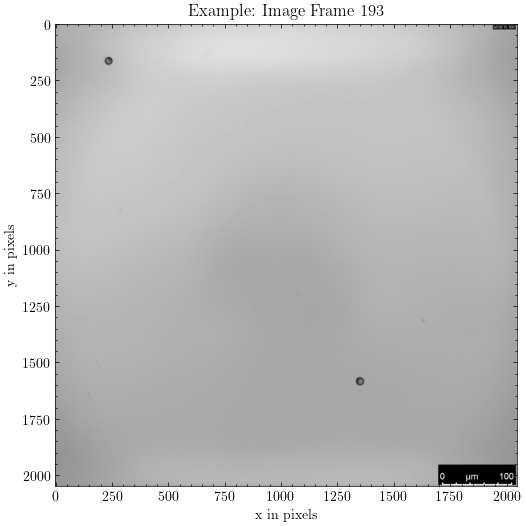

In [4]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im, cmap="gray")
    plt.show()

# Apply Gaussian Blur

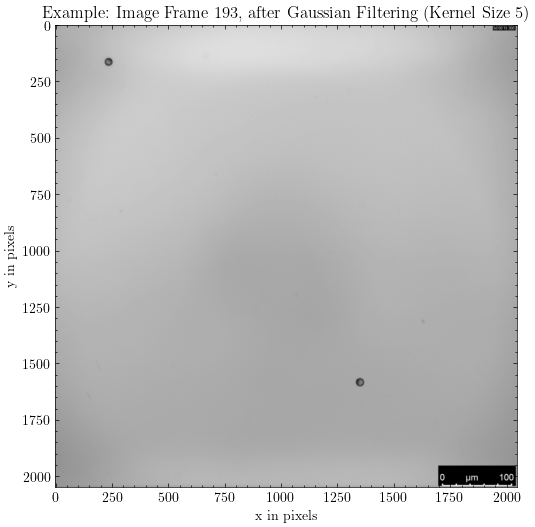

In [5]:
im_blurred = cv.GaussianBlur(im, ksize=(5,5), sigmaX=1)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, after Gaussian Filtering (Kernel Size 5)")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_blurred, cmap="gray")
    plt.show()

# Load trajectory and get ROI

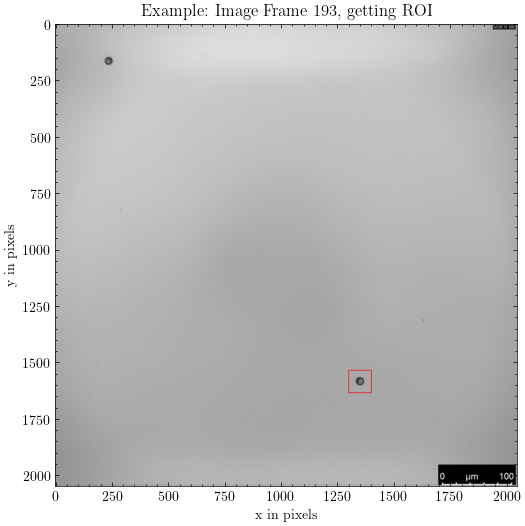

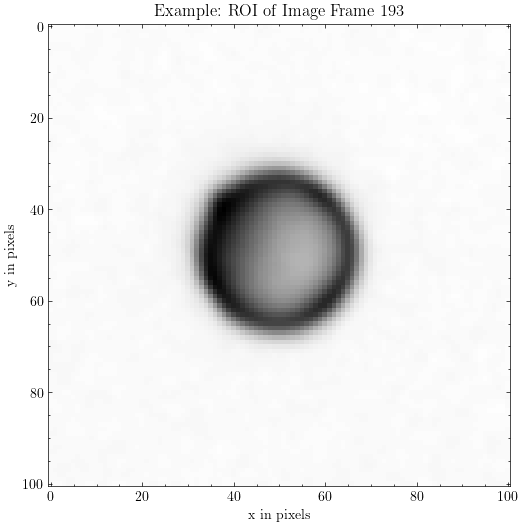

In [6]:
object_trajectory=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
object_trajectory=object_trajectory[1:,:]
stream_string=[]
for i in range(object_trajectory.shape[0]):
    frame_number=round(object_trajectory[i,0])
    im_path="Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(frame_number).zfill(3)+".jpg"
    stream_string.append(im_path)

object_state=object_trajectory[193,:]
a=50
x=round(object_state[1])
y=round(object_state[2])
im_obj_blurred=cv.cvtColor(im_blurred, cv.COLOR_GRAY2RGB)
im_obj_blurred_rect = cv.rectangle(im_obj_blurred, (x-a,y-a), (x+a,y+a), (255, 0, 0), 2)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, getting ROI")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_obj_blurred)
    plt.show()
im_obj_blurred=im_blurred[y-a:y+a+1,x-a:x+a+1]
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: ROI of Image Frame 193")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_obj_blurred,cmap="gray")
    plt.show()

# ROI in one illustration

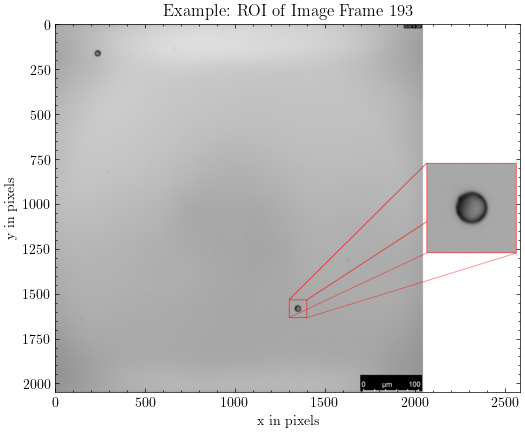

In [7]:
# Open the original image
original_image = Image.open("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t193.jpg")

resize_length=500
# Define the coordinates of the ROI rectangle (left, top, right, bottom)
x1=x-a
x2=x+a
y1=y-a
y2=y+a
roi_coordinates = (x1, y1, x2, y2)  # Update these values

# Crop the ROI from the original image
roi = original_image.crop(roi_coordinates)

# Enlarge the ROI
enlarged_roi = roi.resize((resize_length, resize_length))  # Update new_width and new_height

# Create a blank canvas for the illustration
illustration_width = original_image.width+enlarged_roi.width + 40  # Adjust as needed
illustration_height = max(original_image.height, enlarged_roi.height)  # Adjust as needed
illustration = Image.new("RGB", (illustration_width, illustration_height), "white")

x1_new=original_image.width + 20
y1_new=(illustration_height-resize_length)//2
x2_new=original_image.width + 20 + resize_length
y2_new=(illustration_height+resize_length)//2

# Paste the original image on the canvas
illustration.paste(original_image, (0, 0))  # Adjust the coordinates as needed
draw = ImageDraw.Draw(illustration)
draw.line(
    [(x2, y1), (x2_new, y1_new)],
    fill="red",
    width=3,
)

# Paste the enlarged ROI on the canvas
illustration.paste(enlarged_roi, (original_image.width + 20, (illustration_height-resize_length)//2))  # Adjust the coordinates as needed

draw.rectangle(roi_coordinates, outline="red", width=3)
shape2=(x1_new, y1_new, x2_new, y2_new)
draw.rectangle(shape2, outline="red",width=3)
draw.line(
    [(x1, y1), (x1_new, y1_new)],
    fill="red",
    width=3,
)
draw.line(
    [(x1, y2), (x1_new, y2_new)],
    fill="red",
    width=3,
)
draw.line(
    [(x2, y2), (x2_new, y2_new)],
    fill="red",
    width=3,
)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: ROI of Image Frame 193")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(illustration,cmap="gray")
    plt.show()

# Apply Sobel Gradients

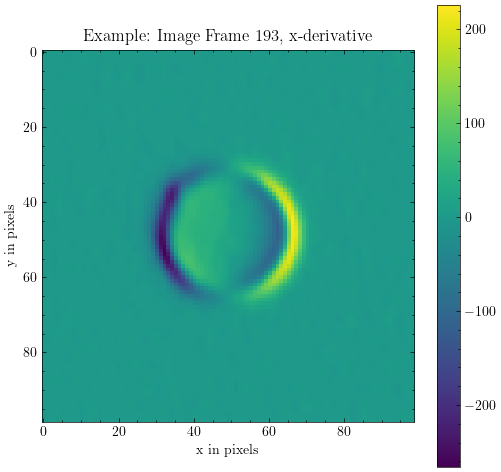

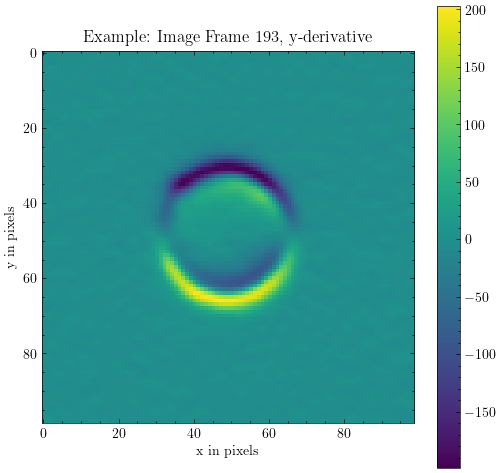

In [8]:
im_obj_blurred=im_obj_blurred.astype(np.float32)
Ix=ndimage.sobel(im_obj_blurred, 1, mode="constant") 
Ix=Ix[1:-1,1:-1]
Iy=ndimage.sobel(im_obj_blurred, 0, mode="constant")
Iy=Iy[1:-1,1:-1]

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, x-derivative")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(Ix)
    plt.colorbar()
    plt.show()

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, y-derivative")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(Iy)
    plt.colorbar()
    plt.show()

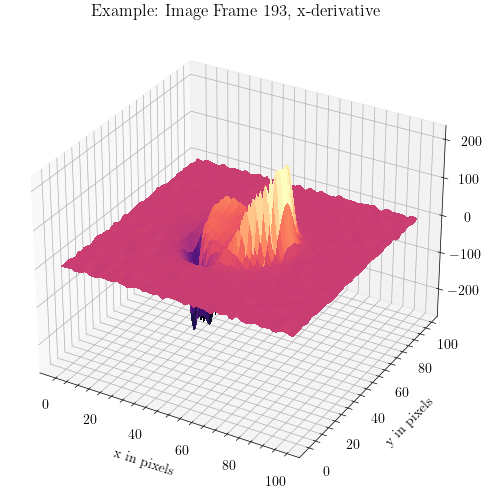

In [9]:
%matplotlib ipympl
X=np.arange(Ix.shape[0])
X,Y=np.meshgrid(X,X)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    plt.title("Example: Image Frame 193, x-derivative")
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Ix, cmap=cm.magma,
                        linewidth=0, antialiased=False)
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    ax.set_zlabel("x-derivative (dimensionless)")
    plt.show()

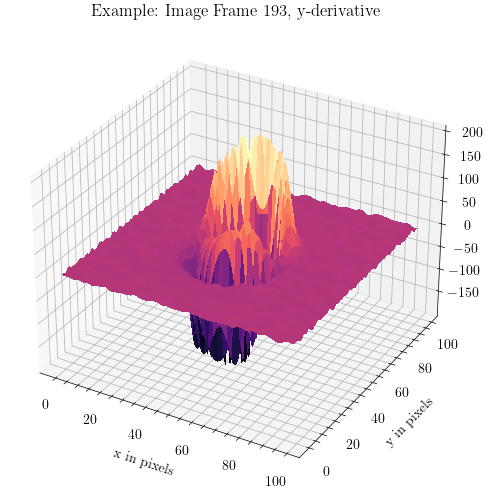

In [10]:
X=np.arange(Iy.shape[0])
X,Y=np.meshgrid(X,X)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    plt.title("Example: Image Frame 193, y-derivative")
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Iy, cmap=cm.magma,
                        linewidth=0, antialiased=False)
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    ax.set_zlabel("y-derivative (dimensionless)")
    plt.show()

# Show Gradient Intensity

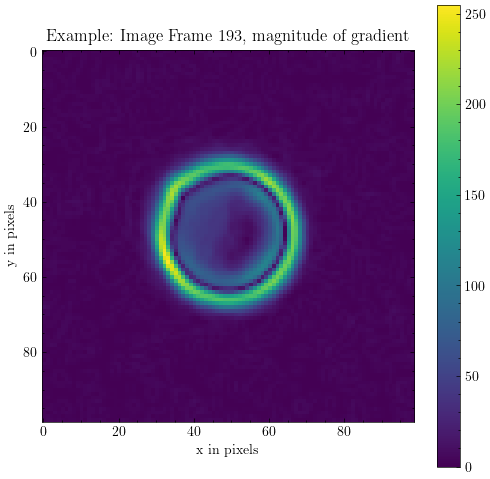

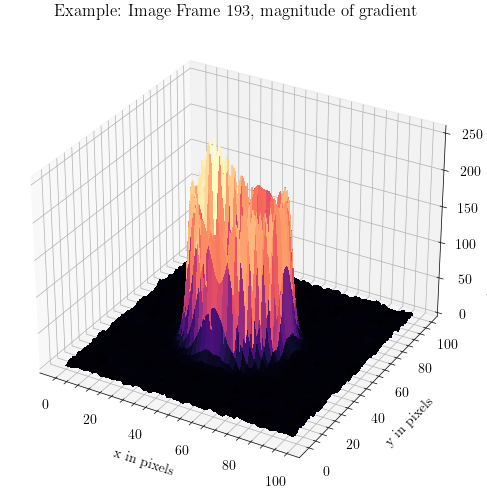

In [11]:
I_magn=np.sqrt(Ix**2+Iy**2)
I_magn = I_magn / np.max(I_magn) * 255
I_theta = np.arctan2(Iy, Ix)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, magnitude of gradient")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(I_magn)
    plt.colorbar()
    plt.show()

X=np.arange(I_magn.shape[0])
X,Y=np.meshgrid(X,X)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    plt.title("Example: Image Frame 193, magnitude of gradient")
    # Plot the surface.
    surf = ax.plot_surface(X, Y, I_magn, cmap=cm.magma,
                        linewidth=0, antialiased=False)
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    ax.set_zlabel("magnitude of gradient (dimensionless)")
    plt.show()

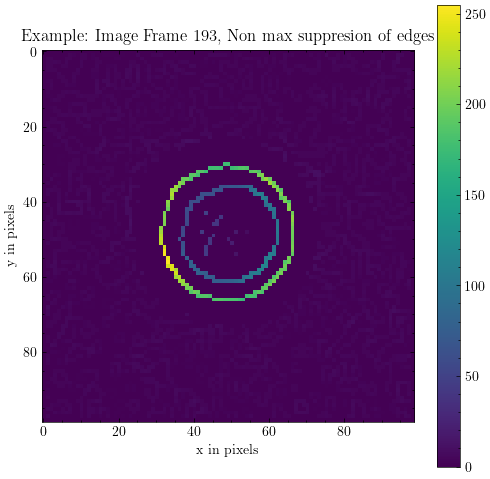

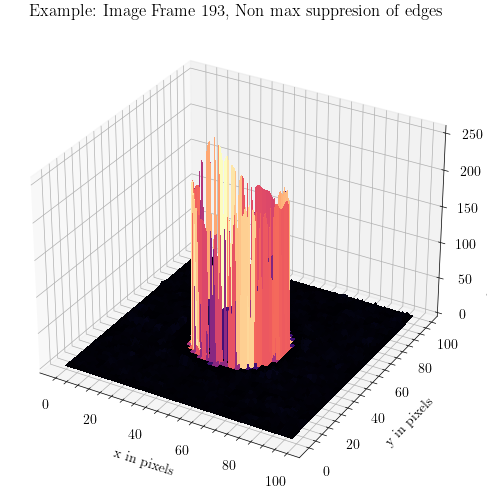

In [12]:
thinned_edges=non_max_suppression(I_theta=I_theta, I_magn=I_magn)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, Non max suppresion of edges")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(thinned_edges)
    plt.colorbar()
    plt.show()

X=np.arange(I_magn.shape[0])
X,Y=np.meshgrid(X,X)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    plt.title("Example: Image Frame 193, Non max suppresion of edges")
    # Plot the surface.
    surf = ax.plot_surface(X, Y, thinned_edges, cmap=cm.magma,
                        linewidth=0, antialiased=False)
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    ax.set_zlabel("magnitude of gradient (dimensionless)")
    plt.show()

# Hysteresis

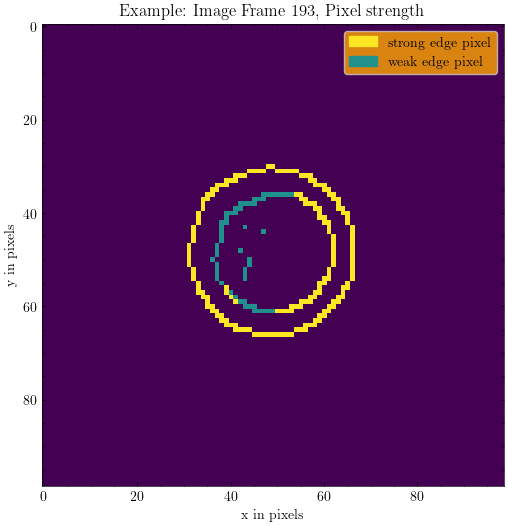

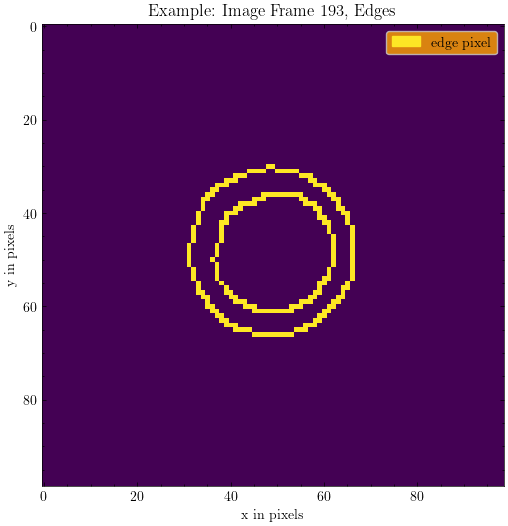

In [13]:
thresh_strong=80
thresh_weak=40
pixel_strength=np.zeros(thinned_edges.shape,dtype=np.uint8)
pixel_strength[(thresh_weak<=thinned_edges) & (thresh_strong>thinned_edges)]=1
pixel_strength[(thresh_strong<=thinned_edges)]=2
Edges=hysteresis_tracking(pixel_strength)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, Pixel strength")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(pixel_strength)
    blue_patch = mpatches.Patch(color=(253/255,231/255,37/255), label='strong edge pixel')
    green_patch = mpatches.Patch(color=(33/255,145/255,140/255), label='weak edge pixel')
    plt.legend(handles=[blue_patch, green_patch],frameon=True, facecolor="orange")
    plt.show()

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, Edges")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    blue_patch = mpatches.Patch(color=(253/255,231/255,37/255), label='edge pixel')
    plt.legend(handles=[blue_patch],frameon=True, facecolor="orange")
    plt.imshow(Edges)
    plt.show()




# Original Canny

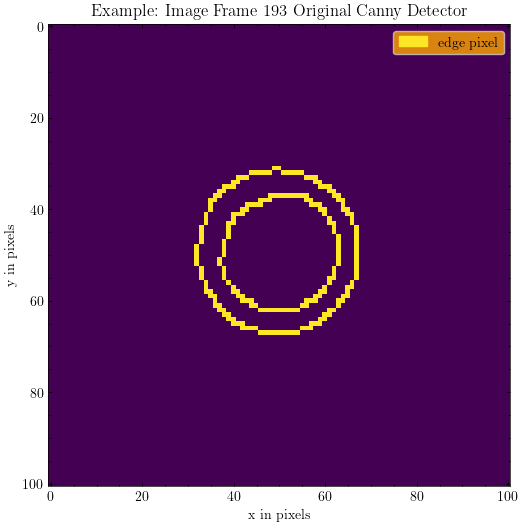

In [14]:
edges_orig = cv.Canny(im_obj_blurred.astype(np.uint8),40,80)

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193 Original Canny Detector")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(edges_orig)
    blue_patch = mpatches.Patch(color=(253/255,231/255,37/255), label='edge pixel')
    plt.legend(handles=[blue_patch],frameon=True, facecolor="orange")
    plt.show()


# Hough Circle Trafo

[49.5 49.5 18.1]


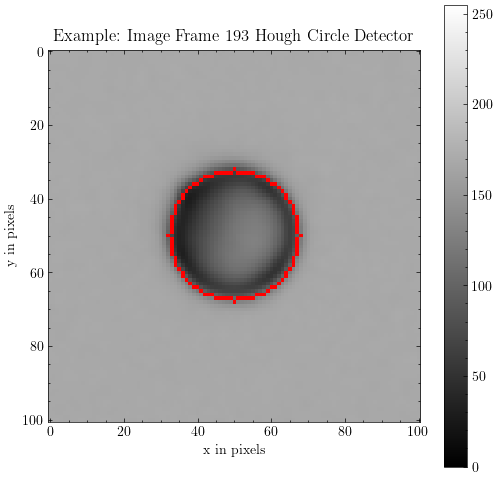

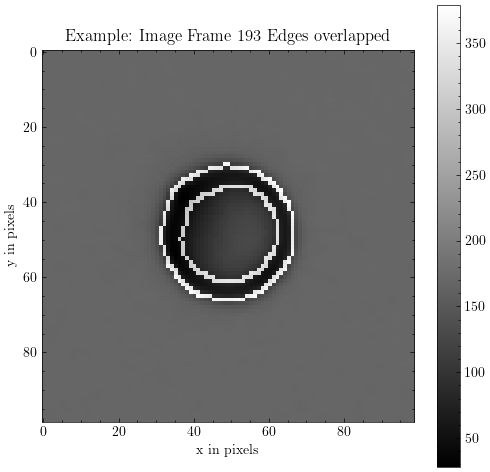

In [15]:
# dp is inverse ratio of the accumulator resolution to the image resolution
# small dp means higher accurate voting (e.g. cirlce values raidus center have more discrete values)
# big dp more likely it is to e.g. miss slightly degenerated circles or detect multiple circles instead of one with a big edge
dp=1
thresh_strong=80
thresh_weak=40
min_dist=10
min_radius=15
max_radius=19


circles = cv.HoughCircles(im_obj_blurred.astype(np.uint8), cv.HOUGH_GRADIENT, dp=dp, minDist=min_dist, param1=thresh_strong, param2=thresh_weak, minRadius=min_radius, maxRadius=max_radius)
circles=np.squeeze(circles)
print(circles)
hough_image=cv.cvtColor(im_obj_blurred.astype(np.uint8), cv.COLOR_GRAY2BGR)
hough_image = cv.circle(hough_image, np.round(circles[0:2]).astype(int), round(circles[-1]), (255, 0, 0), 1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193 Hough Circle Detector")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(hough_image, cmap="gray")
    plt.colorbar()
    plt.show()

im_alt=im_obj_blurred.astype(np.float32)
im_alt=im_alt[1:-1,1:-1]
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193 Edges overlapped")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_alt+Edges.astype(np.float32), cmap="gray")
    plt.colorbar()
    plt.show()


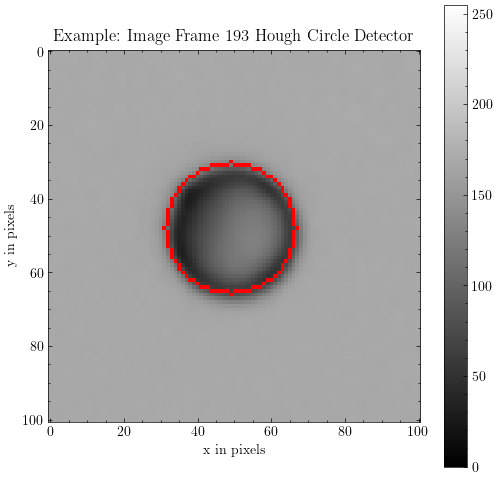

In [16]:
edges_coordinates=np.argwhere(Edges==255)
x_mean=np.mean(edges_coordinates[:,1])
y_mean=np.mean(edges_coordinates[:,0])
hough_image=cv.cvtColor(im_obj_blurred.astype(np.uint8), cv.COLOR_GRAY2BGR)
hough_image = cv.circle(hough_image, (round(x_mean), round(y_mean)), round(circles[-1]), (255, 0, 0), 1)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193 Hough Circle Detector")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(hough_image, cmap="gray")
    plt.colorbar()
    plt.show()



# Hough cirlce on whole image

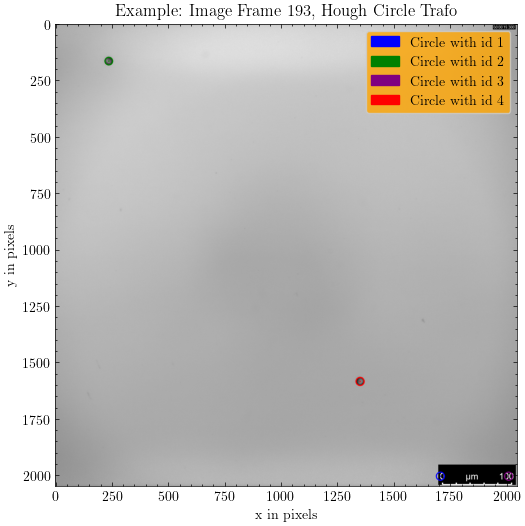

In [17]:
im_bgr=cv.cvtColor(im, cv.COLOR_GRAY2BGR)
circles=hough_circle(im_bgr)
colors=[(255, 0, 0), (0, 128, 0), (128, 0, 128), (0,0,255)]
for i,circle in enumerate(circles):
    center = (round(circle[0]), round(circle[1]))
    # circle outline
    radius = round(circle[2])
    # circle center
    cv.circle(im_bgr, center, 1, colors[i], 3)
    cv.circle(im_bgr, center, radius, colors[i], 3)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [6, 6]
    ax=plt.figure()
    plt.title("Example: Image Frame 193, Hough Circle Trafo")
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_bgr)
    blue_patch = mpatches.Patch(color='blue', label='Circle with id 1')
    green_patch = mpatches.Patch(color='green', label='Circle with id 2')
    purple_patch = mpatches.Patch(color='purple', label='Circle with id 3')
    red_patch = mpatches.Patch(color='red', label='Circle with id 4')
    plt.legend(handles=[blue_patch, green_patch, purple_patch, red_patch],frameon=True, facecolor="orange")
    plt.show()